In [2]:
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O
import os

In [3]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy 
import math
from PIL import Image
import cv2
import albumentations as A # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
#remove warnings(optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm #progress bar
from torchvision.utils import draw_bounding_boxes

In [5]:
print(torch.__version__)
print(torchvision.__version__)

2.1.0
0.16.0


PyCocoTools provides utitilities for dealing with datasets in the COCO format, and if you wanted, you could evaluate the model's
performance on the dataset with some of the utilities provided with this library.

In [6]:
# since our datasets are in cocoformat, we will need pycoco tools
from pycocotools.coco import COCO

In [7]:
#Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

albumentations will be used for data augmentatoin due to its capabilities to deal with bounding boxes in multiple formats

In [8]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600,600),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600,600), # our input size can be 600px
            ToTensorV2()
        ],bbox_params=A.BboxParams(format='coco'))
    return transform

In [9]:
class HelmetDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [10]:
dataset_path = r"/Users/fahdmohammed/Desktop/workspace/helmet-detection/artifacts/10_29_2023_21_13_42/DataIngestionArtifacts"


In [11]:
#load classes
coco = COCO(os.path.join(dataset_path, "train","_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'rider-helmet-bike', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'With Helmet', 'supercategory': 'rider-helmet-bike'},
 2: {'id': 2, 'name': 'Without Helmet', 'supercategory': 'rider-helmet-bike'}}

In [12]:
classes = [ i[1]['name'] for i in categories.items()]
classes

['rider-helmet-bike', 'With Helmet', 'Without Helmet']

In [13]:
len(classes)

3

In [14]:
train_dataset = HelmetDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


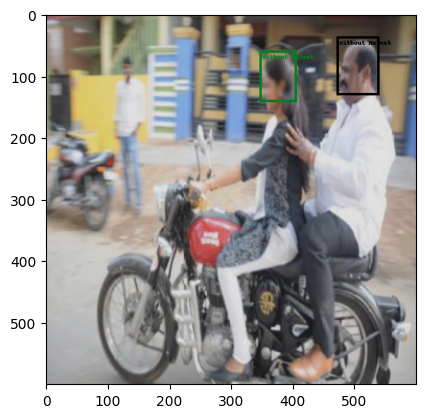

In [15]:
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 225, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1,2,0))

This is a sample image and its bounding boxes, this code does not get the model's output

In [16]:
len(train_dataset)

1182

## Model

Our model is FasterRCNN with a backbone of MobileNetV3-Large. We need to change the output layers because we have just 6 classes but this model was trained on 90 classes.

In [18]:
#loading faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features #we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [20]:
#This is a collationg function for the train dataloader, it allows us to create batches of data that can be easily passed into the model
def collate_fn(batch):
    return tuple(zip(*batch))

In [21]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [22]:
import os 
import sys
import dill 
import logging
def save_object(file_path: str, obj: object) -> None:
    logging.info("Entered the save_object method of utils")

    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, "wb") as file_obj:
        dill.dump(obj, file_obj)
    
    logging.info("Exited the save_object method of utils")


def load_object(file_path: str) -> object:
    logging.info("Entered the load_object method of utils")

    with open(file_path, "rb") as file_obj:
        obj = dill.load(file_obj)
    
    logging.info("Exited the load_object method of utils")

    return obj

In [23]:
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/fahdmohammed/anaconda3/envs/helmet/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/fahdmohammed/anaconda3/envs/helmet/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'HelmetDetection' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [24]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [25]:
model = model.to(device)